# Minimal ML Prediction Example

**Transcription by**:  
Nathan T. Stevens (PNSN)  
**Original Example by**:  
Yiyu Ni (U. Washington) & Congcong Yuan (Harvard)  

This notebook documents an example of predicting event detection and phase arrival probabilities, using a PyTorch implementation of Earthquake Transformer (EQT) with minimal dependency on `SeisBench` utilities for pre-processing, parallelization, and post-processing. 

***ATTRIBUTION***  
It is based almost entirely on the example from the `ELEP` code repository tutorial:
https://github.com/congcy/ELEP/blob/main/docs/tutorials/example_BB_continuous_data_PB_B204.ipynb

This tutorial was brought to our attention through conversations with Yiyu Ni.

In [70]:
# Import "plain vanilla" python modules
import os
import time
# Import PyTorch
import torch
# Import Numpy
import numpy as np
# The seisbench.models module is ONLY used for a convenient way to load the EQT model & weights
import seisbench.models as sbm
# Obspy is used to load, pre-process, and convert data into PyTorch Tensor(s)
from obspy import UTCDateTime, Stream, read

In [2]:
# Indicate which kind of device the PyTorch prediction is being run on
device = torch.device('cpu')

In [3]:
# Load example data
d_src = os.path.join('data','2017-05_BRM','PNW2017','UW','2017','131','GNW.UW.2017.131')
st = read(d_src,fmt='MSEED')
print(st)

6 Trace(s) in Stream:
UW.GNW..BHE | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHN | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHZ | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..ENE | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.995000Z | 100.0 Hz, 8640000 samples
UW.GNW..ENN | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.995000Z | 100.0 Hz, 8640000 samples
UW.GNW..ENZ | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.995000Z | 100.0 Hz, 8640000 samples


In [73]:
# Load pretrained model using SeisBench for convenience
model = sbm.EQTransformer.from_pretrained('pnw')
# Set `pnw` model to no filtering
model.filter_args = None
model.filter_kwargs = None
# Display model arguments
display(model.get_model_args())


## NOTE: This is the last time we use `sbm` in this example!

# Define data windowing & striding
nwin = 6000 # length of data window in samples
step = 1800 # length of data window step in samples

# Define blinding (mutes edge effects)
l_blind, r_blind = 500, 500

{'component_order': 'ZNE',
 'filter_args': None,
 'filter_kwargs': None,
 'grouping': 'instrument',
 'in_channels': 3,
 'in_samples': 6000,
 'classes': 2,
 'phases': 'PS',
 'lstm_blocks': 3,
 'drop_rate': 0.1,
 'original_compatible': False,
 'sampling_rate': 100}

In [5]:
# Send model to device & add annotations about stepping and blinding for class methods `.classify()` and `.annotate()`
model.to(device)
model._annotate_args['overlap'] = ('Overlap between prediction windows in samples\
                                    (only for window prediction models)', step)
model._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                    each side of aeach window prediction', (l_blind, r_blind))

# Place model in evaluation mode
model.eval();


{'component_order': 'ZNE',
 'filter_args': None,
 'filter_kwargs': None,
 'grouping': 'instrument',
 'in_channels': 3,
 'in_samples': 6000,
 'classes': 2,
 'phases': 'PS',
 'lstm_blocks': 3,
 'drop_rate': 0.1,
 'original_compatible': False,
 'sampling_rate': 100}

In [74]:
# Preprocess data
# Get accelerometer data & sort so [Z3] channel codes are first
stN = st.copy().select(channel='?H?').sort(reverse=True)
display(stN)
# Trim to shorter time window
# stN = stN.trim(endtime = stN[0].stats.starttime + 600)

## EITHER ###
# Resample to 100 Hz (redundant in some cases)
# stN = stN.resample(100)
## OR ##
# Change input sampling rate
model.sampling_rate = stN[0].stats.sampling_rate

### DETREND & NORMALIZE ###
# THOU SHALT NORMALIZE THY DATA!
stN = stN.detrend('linear')
stN = stN.normalize()
display(stN)

# Print number of windows expected
nseg = (stN[0].stats.npts - nwin)//step + 2
display(nseg)

3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHN | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHE | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples

3 Trace(s) in Stream:
UW.GNW..BHZ | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHN | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples
UW.GNW..BHE | 2017-05-11T00:00:00.005000Z - 2017-05-11T23:59:59.980000Z | 40.0 Hz, 3456000 samples

1918

In [75]:
# Run prediction using SeisBench window handling & data merging (moderately fast)
ann_st = Stream()
T0_sbm = time.time()
timestamps = {'t0': T0_sbm - T0_sbm}
for _a in model.annotate(stN):
    ann_st += _a
    Ti_sbm = time.time()
    timestamps.update({_a.stats.channel:Ti_sbm - T0_sbm})
TF_sbm = time.time()
timestamps.update({'tF':TF_sbm - T0_sbm})


In [72]:
display(timestamps)



{'t0': 0.0,
 'EQTransformer_Detection': 147.83463788032532,
 'EQTransformer_P': 147.83464193344116,
 'EQTransformer_S': 147.83464288711548,
 'tF': 147.83493185043335}

In [63]:
# Do some visualization (OPTIONAL)
import matplotlib.pyplot as plt
from pyrocko import obspy_compat
obspy_compat.plant()
%matplotlib widget

In [66]:
# Use option to snuffle
s_ann = stN.copy()
for _tr in ann_st.copy():
    _tr.stats.channel = 'eq' + _tr.stats.channel.split('_')[-1][0]
    s_ann += _tr
# Run snufflings & capture outputs
outs = s_ann.snuffle()

(None, <pyrocko.pile.Sorted at 0x2edc1ee50>)

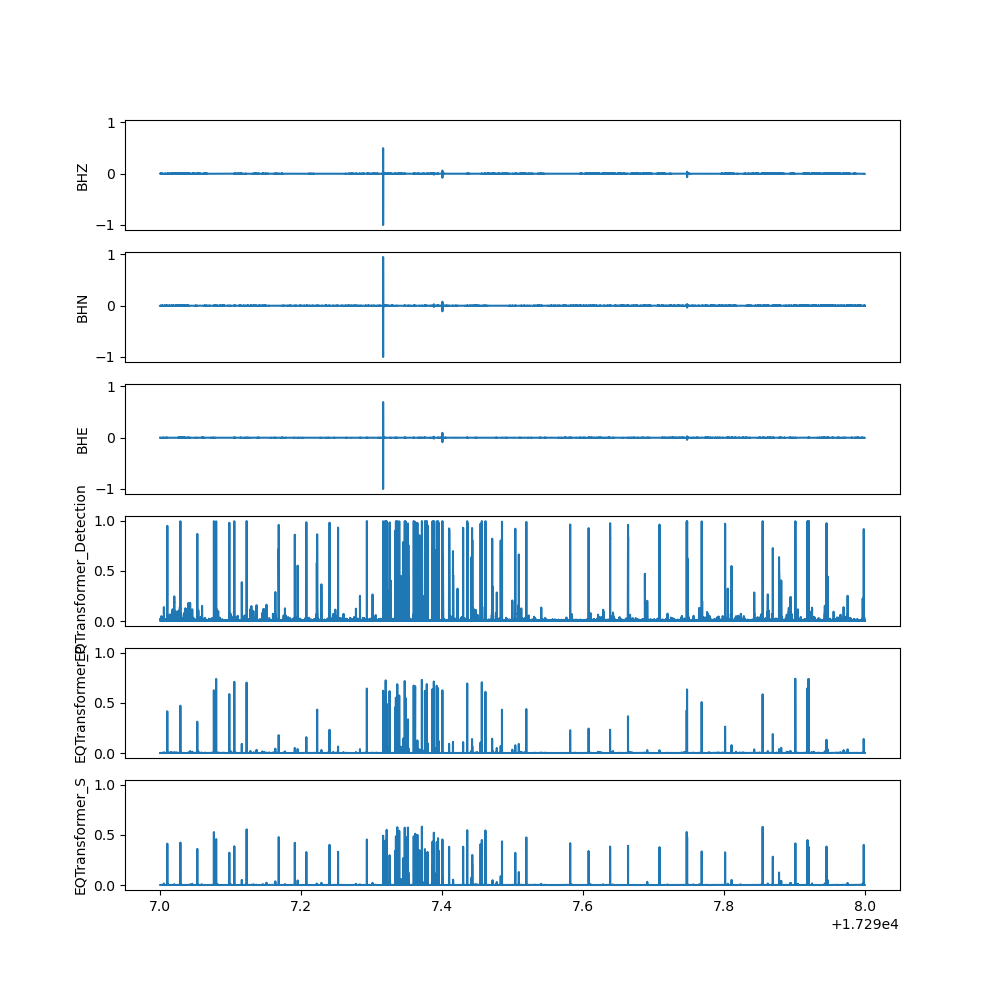

In [59]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(ncols=1, nrows=6)
ax1 = fig.add_subplot(gs[0])
axs = [ax1] + [fig.add_subplot(gs[_i],sharex=ax1,sharey=ax1) for _i in [1,2]]
ax2 = fig.add_subplot(gs[3],sharex=ax1)
axs += [ax2]
axs += [fig.add_subplot(gs[_i],sharex=ax2,sharey=ax2) for _i in [4,5]]
for _i, _tr in enumerate(stN):
    axs[_i].plot(_tr.times(type='matplotlib'),_tr.data)
    axs[_i].xaxis.set_visible(False)
    axs[_i].set_ylabel(_tr.stats.channel)

for _i, _tr in enumerate(ann_st):
    __i = _i + 3
    axs[__i].plot(_tr.times(type='matplotlib'),_tr.data)
    if _i < 2: 
        axs[__i].xaxis.set_visible(False)
    axs[__i].set_ylabel(_tr.stats.channel)

In [85]:
## NOW, DO THE "BARE METAL" MODEL APPROACH
tick = time.time()

nseg = (stN[0].stats.npts - nwin)//step + 2
# nseg = (stN[0].stats.npts - nwin)//step + 2 # This assumes last window is nwin long
# TODO: create case for handling len("data_segment") < nwin
# Create segmented data with assistance from the SeisBench model for book-keeping
stN_seg = model.annotate_stream_pre(stN.copy(), argdict=model._annotate_args)
sNdata = np.array(stN_seg)[[0,1,2],:]
display(sNdata)

## PREALLOCATE SPACE ##
# Preallocate space for windowed data
windows_max = np.zeros(shape=(nseg, 3, nwin), dtype = np.float32)
# Preallocate index vector
windows_idx = np.zeros(nseg, dtype=np.int32)
# Preallocate space for data iterant 
_windows = np.zeros(shape=(nseg, 3, nwin), dtype=np.float32)


## Create Taper
taper_npts = 6
taper = 0.5 * (1. + np.cos(np.linspace(np.pi, 2.* np.pi, taper_npts)))

# Iterate across segments to preprocess data
for _iseg in tqdm(range(nseg)):
    # Get data vector index for start of each window
    idx = _iseg * step
    # Grab data segment
    try:
        _windows[_iseg, :] = sNdata[:, idx:idx + nwin]
    except:
        _sNiseg = sNdata[:, idx:idx + nwin]

    # Demean data (TODO: check np.mean --> np.nanmean to handle masked arrays)
    _windows[_iseg, :] -= np.nanmean(_windows[_iseg, :],\
                                     axis=-1, keepdims=True)
    # Apply maxnorm (TODO: check np.max --> np.nanmax to handle masked arrays)
    windows_max[_iseg, :] = _windows[_iseg, :] /\
                            (np.nanmax(np.abs(_windows[_iseg, :]),\
                                       axis = -1, keepdims=True))
    # TODO: Include 0-padding option for gappy data
    # Update window indexing array
    windows_idx[_iseg] = idx

## APPLY TAPER ##
# Apply to window heads
windows_max[:, :, :taper_npts] *= taper
# Apply to window tails
windows_max[:, :, -taper_npts:] *= taper


# Remove data iterant to recover memory
del _windows

tock = time.time()
print(f'Preprocessing too {tock - tick: .3f} seconds')

array([[-9.27470427e-05, -1.18850398e-04, -9.54955792e-05, ...,
        -1.51658154e-04, -1.53032422e-04, -1.61275881e-04],
       [ 1.53557891e-04,  1.47783757e-04,  1.51633254e-04, ...,
        -1.37816418e-05, -1.66686866e-05, -8.00737497e-06],
       [-2.94274867e-04, -2.84633889e-04, -2.83150634e-04, ...,
         1.26902154e-04,  1.19486073e-04,  1.17261272e-04]])

 97%|█████████▋| 1851/1918 [00:00<00:00, 18502.21it/s]/var/folders/9_/bj6tpb_93rd3b2tr7466ztqr0000gn/T/ipykernel_1573/853619481.py:41: RuntimeWarning: invalid value encountered in divide
  windows_max[_iseg, :] = _windows[_iseg, :] /\
100%|██████████| 1918/1918 [00:00<00:00, 18329.51it/s]

Preprocessing too  1.486 seconds


In [96]:
# A fix for non-standard-length input vectors
np.concatenate([_sNiseg,np.zeros(shape=(3,nwin - _sNiseg.shape[1]))],axis=1).shape

(3, 6000)

In [98]:
### RUN BATCH PREDICTION ###
tick = time.time()
# Preallocate space for predictions (include detection curve, unlike original example)
preds = np.zeros(shape=(3, nseg, nwin), dtype = np.float32)

# Convert from Numpy ndarrays to PyTorch Tensor
windows_max_tt = torch.Tensor(windows_max)
# Run Prediction
_torch_pred = model(windows_max_tt.to(device))
# Write predictions
# Detection Probability
preds[0, :] = _torch_pred[0].detach().cpu().numpy()
# P-pick Probability 
preds[1, :] = _torch_pred[1].detach().cpu().numpy()
# S-pick probability
preds[2, :] = _torch_pred[2].detach().cpu().numpy()

tock = time.time()
print(f'Prediction on {nseg} data windows took {tock - tick} seconds')
print(f'{(tock - tick)/nseg} seg/segment')

Prediction on 1918 data windows took 88.58149766921997 seconds
0.04618430535412928 segments/sec
